In [6]:
import cv2
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
classes = []
with open("coco.names", "r") as f:
    classes = [x.strip() for x in f.readlines()]
layer_name = net.getLayerNames()
output_layers = [layer_name[i-1] for i in net.getUnconnectedOutLayers()]

In [7]:
img = cv2.imread(r"C://Users/Xavier/Desktop/test.png")
# img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, c = img.shape
blob = cv2.dnn.blobFromImage(img, 1.0 / 255.0, (416, 416), (0, 0, 0), True, crop=False)

In [8]:
img.shape

(204, 362, 3)

In [9]:
from PIL import Image
import numpy as np
np.array(Image.open(r"C://Users/Xavier/Desktop/test.png")).shape

(204, 362, 4)

In [10]:
import numpy as np
class_ids = []
confidences = []
boxes = []
net.setInput(blob)
outs = net.forward(output_layers)

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0]*width)
            center_y = int(detection[1]*height)
            w, h = int(detection[2]*width), int(detection[3]*height)
            x = int(center_x - w/2)
            y = int(center_y - h/2)
            
            boxes.append([x,y,w,h])
            confidences.append(confidence)
            class_ids.append(class_id)

In [24]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
res = [boxes[i] for i in indexes]
for x,y,w,h  in res:
    cv2.rectangle(img, (x,y),(x+w, y+h), (0,0,255),1)
cv2.imshow("img", img)
cv2.waitKey(0)

-1

In [25]:
x,y,w,h = res[1]

<IPython.core.display.Javascript object>

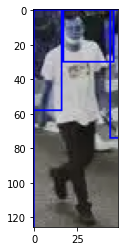

In [26]:
plt.imshow(img[y:y+h, x:x+w])

In [5]:
import torch
import torch.nn as nn
from collections import OrderedDict

BN_MOMENTUM = 0.1
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion,
                                  momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck_CAFFE(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_CAFFE, self).__init__()
        # add stride to conv1x1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion,
                                  momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class PoseResNet(nn.Module):

    def __init__(self, block, layers, cfg, **kwargs):
        self.inplanes = 64
        extra = cfg.MODEL.EXTRA
        self.deconv_with_bias = extra.DECONV_WITH_BIAS

        super(PoseResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # used for deconv layers
        self.deconv_layers = self._make_deconv_layer(
            extra.NUM_DECONV_LAYERS,
            extra.NUM_DECONV_FILTERS,
            extra.NUM_DECONV_KERNELS,
        )

        self.final_layer = nn.Conv2d(
            in_channels=extra.NUM_DECONV_FILTERS[-1],
            out_channels=cfg.MODEL.NUM_JOINTS,
            kernel_size=extra.FINAL_CONV_KERNEL,
            stride=1,
            padding=1 if extra.FINAL_CONV_KERNEL == 3 else 0
        )

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _get_deconv_cfg(self, deconv_kernel, index):
        if deconv_kernel == 4:
            padding = 1
            output_padding = 0
        elif deconv_kernel == 3:
            padding = 1
            output_padding = 1
        elif deconv_kernel == 2:
            padding = 0
            output_padding = 0

        return deconv_kernel, padding, output_padding

    def _make_deconv_layer(self, num_layers, num_filters, num_kernels):
        assert num_layers == len(num_filters), \
            'ERROR: num_deconv_layers is different len(num_deconv_filters)'
        assert num_layers == len(num_kernels), \
            'ERROR: num_deconv_layers is different len(num_deconv_filters)'

        layers = []
        for i in range(num_layers):
            kernel, padding, output_padding = \
                self._get_deconv_cfg(num_kernels[i], i)

            planes = num_filters[i]
            layers.append(
                nn.ConvTranspose2d(
                    in_channels=self.inplanes,
                    out_channels=planes,
                    kernel_size=kernel,
                    stride=2,
                    padding=padding,
                    output_padding=output_padding,
                    bias=self.deconv_with_bias))
            layers.append(nn.BatchNorm2d(planes, momentum=BN_MOMENTUM))
            layers.append(nn.ReLU(inplace=True))
            self.inplanes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.deconv_layers(x)
        x = self.final_layer(x)

        return x

resnet_spec = {18: (BasicBlock, [2, 2, 2, 2]),
               34: (BasicBlock, [3, 4, 6, 3]),
               50: (Bottleneck, [3, 4, 6, 3]),
               101: (Bottleneck, [3, 4, 23, 3]),
               152: (Bottleneck, [3, 8, 36, 3])}


def get_pose_net():
    block_class, layers = resnet_spec[50]
    model = PoseResNet(block_class, layers)
    return model